<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Content-based Course Recommender System using Course Similarities**


In one of the previous lab, you have learned and practiced how to calculate the similarity between two courses using Bag of Words (BoW) features. For example, the similarity between course1 `Machine Learning for Everyone` and course2 `Machine Learning for Beginners` are `75%` as shown below.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_2/images/course_sim.png)


As we mentioned before, the content-based recommender system is highly based on the similarity calculation among items. The similarity or closeness of items is measured based on the similarity in the content or features of those items. The course genres are important features, and in addition to that, the BoW value is another important type of feature to represent course textual content. 


In this lab, you will apply the course similarities metric to recommend  new courses which are similar to a user's presently enrolled courses.


## Objectives


After completing this lab you will be able to:


* Obtain the similarity between courses from a course similarity matrix
* Use the course similarity matrix to find and recommend new courses which are similar to enrolled courses


----


## Prepare and setup lab environment


Let's first install and import the required libraries:


In [1]:
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install matplotlib

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [3]:
# also set a random state
rs = 123

Next, let's load a pre-made course similarity matrix. If you are interested, you could easily calculate such a similarity matrix by iterating through all possible course pairs and calculating their similarities.


In [4]:
sim_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/sim.csv"

In [5]:
sim_df = pd.read_csv(sim_url)
sim_df

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,1.000000,0.088889,0.088475,0.065556,0.048810,0.104685,0.065202,0.143346,0.000000,0.024405,...,0.012695,0.070225,0.058224,0.046610,0.025850,0.033944,0.076825,0.072898,0.039276,0.121113
1,0.088889,1.000000,0.055202,0.057264,0.012182,0.078379,0.032545,0.119251,0.044162,0.000000,...,0.180593,0.124631,0.087187,0.093060,0.019354,0.028239,0.063911,0.138270,0.031367,0.076940
2,0.088475,0.055202,1.000000,0.026463,0.039406,0.000000,0.000000,0.154303,0.000000,0.000000,...,0.040996,0.037796,0.013430,0.037630,0.000000,0.018270,0.082698,0.133400,0.012684,0.000000
3,0.065556,0.057264,0.026463,1.000000,0.000000,0.250490,0.390038,0.000000,0.000000,0.000000,...,0.151882,0.420084,0.427908,0.055764,0.000000,0.094759,0.030638,0.017443,0.018796,0.158073
4,0.048810,0.012182,0.039406,0.000000,1.000000,0.000000,0.000000,0.085126,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.096877,0.000000,0.060474,0.030415,0.129871,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.033944,0.028239,0.018270,0.094759,0.060474,0.064851,0.053856,0.039467,0.036539,0.060474,...,0.047186,0.116008,0.137406,0.211743,0.256220,1.000000,0.211520,0.168595,0.129766,0.263734
303,0.076825,0.063911,0.082698,0.030638,0.030415,0.000000,0.000000,0.119098,0.055132,0.045622,...,0.177989,0.092381,0.145126,0.527636,0.249675,0.211520,1.000000,0.242269,0.416067,0.178384
304,0.072898,0.138270,0.133400,0.017443,0.129871,0.009285,0.000000,0.254274,0.094165,0.025974,...,0.153128,0.105191,0.138692,0.281108,0.132977,0.168595,0.242269,1.000000,0.220159,0.128902
305,0.039276,0.031367,0.012684,0.018796,0.000000,0.015008,0.024926,0.082199,0.076102,0.055978,...,0.149234,0.093962,0.162170,0.476644,0.222350,0.129766,0.416067,0.220159,1.000000,0.126274


The similarity matrix is a real number, symmetric metric with each element representing the similarity value (ranged 0 to 1) between course index `i` and course index `j`. 


We could use `seaborn` to visualize the similarity metric, and since it is symmetric, we can just show the triangular  matrix (lower left):


<Axes: >

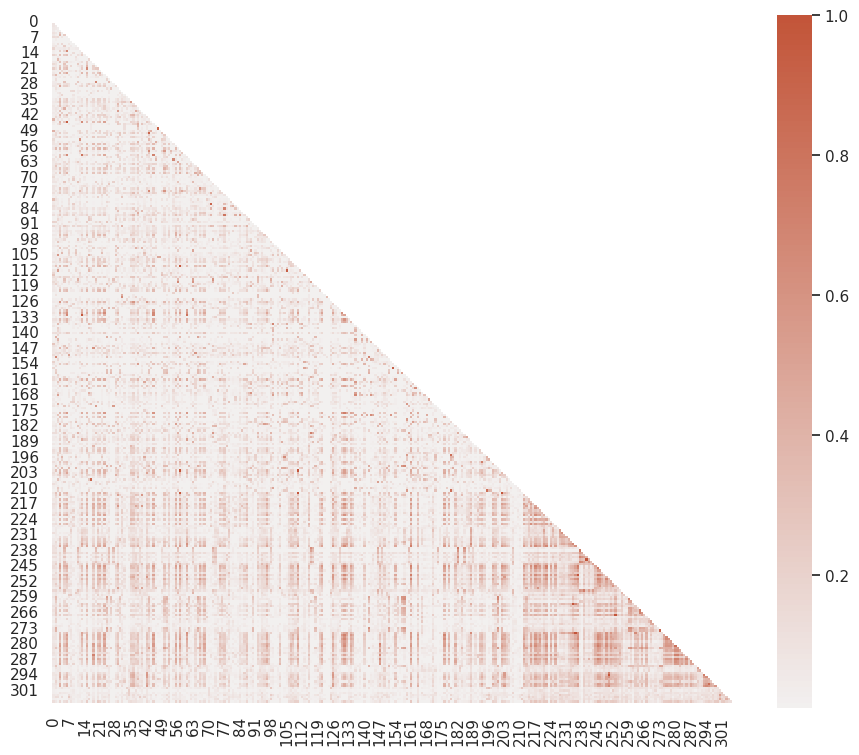

In [6]:
# Configure seaborn to set the plot style to 'white'
sns.set_theme(style="white")

# Create a mask for the upper triangle of the similarity matrix
mask = np.triu(np.ones_like(sim_df, dtype=bool))

# Create a new figure and axis for the heatmap
_, ax = plt.subplots(figsize=(11, 9))

# Create a diverging color palette for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot a similarity heat map using seaborn's heatmap function
sns.heatmap(sim_df, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True)


As we can see from the heatmap; there are many hot spots, which means many courses are similar to each other. Such patterns suggest that it is possible to build a recommender system based on course similarities. 


Let's take a look at a quick example:


In [7]:
# Let's first load the course content and BoW dataset
course_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_processed.csv"
course_df = pd.read_csv(course_url)
bow_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/courses_bows.csv"
bow_df = pd.read_csv(bow_url)

In [8]:
bow_df.head()

,doc_index,doc_id,token,bow
0,0,ML0201EN,ai,2
1,0,ML0201EN,apps,2
2,0,ML0201EN,build,2
3,0,ML0201EN,cloud,1
4,0,ML0201EN,coming,1


First, we want to mention that the matrix indices are course indices (such as `0, 1, 2, 3`). Very often we need to query the actual course ids (such as `ML0151EN` and `ML0101ENv3`) based on course indices and vice versa. We can save the course id's and indices into two dictionaries for late queries:


Then, based on the `doc_index` and `doc_id` columns, we create an index to id mapping and another id to index mapping in two Python dictionaries:


In [9]:
# Create course id to index and index to id mappings
def get_doc_dicts(bow_df):
    # Group the DataFrame by course index and ID, and get the maximum value for each group
    grouped_df = bow_df.groupby(['doc_index', 'doc_id']).max().reset_index(drop=False)
    # Create a dictionary mapping indices to course IDs
    idx_id_dict = grouped_df[['doc_id']].to_dict()['doc_id']
    # Create a dictionary mapping course IDs to indices
    id_idx_dict = {v: k for k, v in idx_id_dict.items()}
    # Clean up temporary DataFrame
    del grouped_df
    return idx_id_dict, id_idx_dict

Now suppose we have two example courses:


In [10]:
course1 = course_df[course_df['COURSE_ID'] == "ML0151EN"]
course1

,COURSE_ID,TITLE,DESCRIPTION
200,ML0151EN,machine learning with r,this machine learning with r course dives into...


In [11]:
course2 = course_df[course_df['COURSE_ID'] == "ML0101ENv3"]
course2

,COURSE_ID,TITLE,DESCRIPTION
158,ML0101ENv3,machine learning with python,machine learning can be an incredibly benefici...


From their titles we can see they are all about machine learning. As such, they should be very similar to each other. Let's try to find their similarity in the similarity matrix.

With their course ids, we can use the `id_idx_dict` dictionary to query their row and column index on the similarity matrix:


In [12]:
idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)
idx1 = id_idx_dict["ML0151EN"]
idx2 = id_idx_dict["ML0101ENv3"]
print(f"Course 1's index is {idx1} and Course 2's index is {idx2}")

Course 1's index is 200 and Course 2's index is 158


Then we can locate their similarity value in row 200 and col 158, `sim_matrix[200][158]`:


In [13]:
sim_matrix = sim_df.to_numpy()

In [14]:
sim = sim_matrix[idx1][idx2]
sim

0.6626221399549089

It's about 66% meaning these two courses are quite similar to each other.


### Find courses which are similar enough to your enrolled courses.


Now you know how to easily use the pre-computed similarity matrix to query the similarity between any two courses. Do you want to make some course recommendations for yourself?

Let's assume you are an end-user of the online course platform and already audited or completed some courses previously. Next, you expect the system would recommend similar courses based on your enrollments history.


From the full course list, choose any courses that may interest you, such as those machine learning related courses:


In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)
course_df[['COURSE_ID', 'TITLE']]

,COURSE_ID,TITLE
0,ML0201EN,robots are coming build iot apps with watson swift and node red
1,ML0122EN,accelerating deep learning with gpu
2,GPXX0ZG0EN,consuming restful services using the reactive jax rs client
3,RP0105EN,analyzing big data in r using apache spark
4,GPXX0Z2PEN,containerizing packaging and running a spring boot application
5,CNSC02EN,cloud native security conference data security
6,DX0106EN,data science bootcamp with r for university proffesors
7,GPXX0FTCEN,learn how to use docker containers for iterative development
8,RAVSCTEST1,scorm test 1
9,GPXX06RFEN,create your first mongodb database


In [16]:
# Reset pandas settings
pd.reset_option('display.max_rows')
pd.reset_option('max_colwidth')

_Browse the course list and choose your interested courses_ 


In [20]:
enrolled_course_ids = ["ML0201EN","PXX0ZG0EN","GPXX0Z2PEN"] # add your interested coures id to the list

In [21]:
enrolled_courses = course_df[course_df['COURSE_ID'].isin(enrolled_course_ids)]
enrolled_courses

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...


Given the full course list, we can find those unselected courses:


In [22]:
all_courses = set(course_df['COURSE_ID'])

In [23]:
unselected_course_ids = all_courses.difference(enrolled_course_ids)
unselected_course_ids

{'AI0111EN',
 'BC0101EN',
 'BC0201EN',
 'BC0202EN',
 'BD0101EN',
 'BD0111EN',
 'BD0115EN',
 'BD0121EN',
 'BD0123EN',
 'BD0131EN',
 'BD0133EN',
 'BD0135EN',
 'BD0137EN',
 'BD0141EN',
 'BD0143EN',
 'BD0145EN',
 'BD0151EN',
 'BD0153EN',
 'BD0211EN',
 'BD0212EN',
 'BD0221EN',
 'BD0223EN',
 'BENTEST4',
 'CB0101EN',
 'CB0103EN',
 'CB0105ENv1',
 'CB0201EN',
 'CC0101EN',
 'CC0103EN',
 'CC0120EN',
 'CC0121EN',
 'CC0150EN',
 'CC0201EN',
 'CC0210EN',
 'CC0250EN',
 'CC0271EN',
 'CL0101EN',
 'CNSC02EN',
 'CO0101EN',
 'CO0193EN',
 'CO0201EN',
 'CO0301EN',
 'CO0302EN',
 'CO0401EN',
 'COM001EN',
 'CP0101EN',
 'DA0101EN',
 'DA0151EN',
 'DA0201EN',
 'DAI101EN',
 'DB0101EN',
 'DB0111EN',
 'DB0113EN',
 'DB0115EN',
 'DB0151EN',
 'DE0205EN',
 'DJ0101EN',
 'DP0101EN',
 'DS0101EN',
 'DS0103EN',
 'DS0105EN',
 'DS0107',
 'DS0110EN',
 'DS0132EN',
 'DS0201EN',
 'DS0301EN',
 'DS0321EN',
 'DV0101EN',
 'DV0151EN',
 'DW0101EN',
 'DX0106EN',
 'DX0107EN',
 'DX0108EN',
 'EE0101EN',
 'GPXX01AVEN',
 'GPXX01DCEN',
 'GPXX01

Now, you can iterate each unselect course and check if it is similar enough to any of your selected courses. If the similarity is larger than a threshold such as 0.5 or 0.6, then add it to your course recommendation list:


_Complete the following method to recommend courses which are similar to your enrolled courses_


In [24]:
def recommend_similar_courses(user_id, num_recommendations=10):
    """
    Recommend courses that are similar to the courses the user has already enrolled in.
    
    Args:
        user_id: The ID of the user to generate recommendations for
        num_recommendations: Maximum number of recommendations to return
        
    Returns:
        recommendations_df: DataFrame containing recommended courses with similarity scores
    """
    # Get the courses the user is already enrolled in
    enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
    enrolled_courses_set = set(enrolled_courses)
    
    # Get all available courses
    all_courses = set(course_genres_df['COURSE_ID'].values)
    
    # Find courses the user has not enrolled in yet
    unknown_courses = all_courses.difference(enrolled_courses_set)
    
    # Get genre vectors for enrolled courses
    enrolled_course_genres = course_genres_df[course_genres_df['COURSE_ID'].isin(enrolled_courses)]
    
    # Get genre vectors for unknown courses
    unknown_course_genres = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
    
    # Initialize list to store all similarity scores
    all_similarities = []
    
    # For each enrolled course, find similar courses
    for _, enrolled_course_row in enrolled_course_genres.iterrows():
        enrolled_course_id = enrolled_course_row['COURSE_ID']
        enrolled_course_title = enrolled_course_row['TITLE']
        enrolled_course_vector = enrolled_course_row.iloc[2:].values
        
        # Calculate norm of enrolled course vector for cosine similarity
        enrolled_norm = np.linalg.norm(enrolled_course_vector)
        if enrolled_norm == 0:
            continue
            
        for _, unknown_course_row in unknown_course_genres.iterrows():
            unknown_course_id = unknown_course_row['COURSE_ID']
            unknown_course_title = unknown_course_row['TITLE']
            unknown_course_vector = unknown_course_row.iloc[2:].values
            
            # Calculate norm of unknown course vector
            unknown_norm = np.linalg.norm(unknown_course_vector)
            if unknown_norm == 0:
                continue
                
            # Calculate cosine similarity
            dot_product = np.dot(enrolled_course_vector, unknown_course_vector)
            cosine_similarity = dot_product / (enrolled_norm * unknown_norm)
            
            all_similarities.append({
                'enrolled_course_id': enrolled_course_id,
                'enrolled_course_title': enrolled_course_title,
                'recommended_course_id': unknown_course_id,
                'recommended_course_title': unknown_course_title,
                'similarity_score': cosine_similarity
            })
    
    # Convert to DataFrame
    all_similarities_df = pd.DataFrame(all_similarities)
    
    # Return empty DataFrame if no similarities found
    if all_similarities_df.empty:
        return pd.DataFrame(columns=['enrolled_course_id', 'enrolled_course_title', 
                                    'recommended_course_id', 'recommended_course_title', 
                                    'similarity_score'])
    
    # Sort by similarity score and remove duplicates to get top recommendations
    all_similarities_df = all_similarities_df.sort_values('similarity_score', ascending=False)
    all_similarities_df = all_similarities_df.drop_duplicates(subset='recommended_course_id', keep='first')
    recommendations_df = all_similarities_df.head(num_recommendations)
    
    return recommendations_df

The completed `generate_recommendations_user(...)` may ouput a dictionary like this:


{'ML0151EN': 0.6626221399549089,
 'excourse47': 0.6347547807096177,
 'excourse46': 0.6120541193300345}


### Generate course recommendations based on course similarities for all test uesrs


In the previous task, you made some recommendations for yourself. Next, let's try to make recommendations for all the test users in the test dataset.


In [25]:
test_users_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
test_users_df = pd.read_csv(test_users_url)

Let's look at how many test users we have in the dataset.


In [26]:
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()
print(f"Total numbers of test users {len(test_user_ids)}")

Total numbers of test users 33901


_TODO: Complete the ``generate_recommendations_for_all()`` method to generate recommendations for all users. You may implement the task with different solutions_


In [27]:
def generate_recommendations_for_one_user(user_id, sim_df, course_df, bow_df, top_n=10):
    """
    Generate recommendations for a single user based on course similarities.
    
    Args:
        user_id: The ID of the user to generate recommendations for
        sim_df: Course similarity matrix dataframe
        course_df: Course content dataframe
        bow_df: Course BoW features dataframe
        top_n: Number of top recommendations to return
        
    Returns:
        recommended_courses: List of recommended course IDs
        scores: List of similarity scores
    """
    # Get the courses the user has already enrolled in
    enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
    
    # Get all available courses
    all_course_ids = course_df['COURSE_ID'].unique().tolist()
    
    # Find courses the user hasn't enrolled in yet
    candidate_courses = [c for c in all_course_ids if c not in enrolled_courses]
    
    # Compute similarity scores for each candidate course
    course_scores = []
    
    for candidate in candidate_courses:
        # Calculate average similarity between this candidate course and all enrolled courses
        similarities = []
        
        for enrolled in enrolled_courses:
            # Find similarity score between enrolled and candidate course
            if enrolled in sim_df.columns and candidate in sim_df.index:
                sim_score = sim_df.loc[candidate, enrolled]
                similarities.append(sim_score)
        
        # Calculate average similarity if there are valid scores
        if similarities:
            avg_similarity = sum(similarities) / len(similarities)
            course_scores.append((candidate, avg_similarity))
    
    # Sort by similarity score and get top N recommendations
    course_scores.sort(key=lambda x: x[1], reverse=True)
    top_recommendations = course_scores[:top_n]
    
    # Split into separate lists for courses and scores
    recommended_courses = [item[0] for item in top_recommendations]
    scores = [item[1] for item in top_recommendations]
    
    return recommended_courses, scores

def generate_recommendations_for_all():
    """
    Generate recommendations for all users based on course similarities.
    
    Returns:
        users (list): List of user IDs.
        courses (list): List of recommended course IDs.
        sim_scores (list): List of similarity scores.
    """
    users = []
    courses = []
    sim_scores = []
    
    # Load required dataframes
    sim_df = pd.read_csv(sim_url)
    course_df = pd.read_csv(course_url)
    bow_df = pd.read_csv(bow_url)
    
    # Get unique user IDs
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    
    # Generate recommendations for each user
    for user_id in test_user_ids:
        # Get recommendations for this user
        recommended_courses, scores = generate_recommendations_for_one_user(user_id, sim_df, course_df, bow_df)
        
        # Add to result lists
        for i in range(len(recommended_courses)):
            users.append(user_id)
            courses.append(recommended_courses[i])
            sim_scores.append(scores[i])
    
    return users, courses, sim_scores


After you completed the `generate_recommendations_for_all()` function, you can call it to save the results into a dataframe:


In [ ]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
res_df

Similar to the previous user profile and course genre lab, with the recommendations generated for each user, you need to write some extra analytic code to answer the following questions:


- On average, how many new/unseen courses have been recommended to each user?
- What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users?


For example, suppose we have only 3 test users, each user receives the following recommendations:


- User1: ['course1', 'course2']
- User2: ['course3', 'course4']
- User3: ['course3', 'course4', 'course5']


Then, the average recommended courses per user is $(2 + 2 + 3) / 3 = 2.33$. The top-2 recommended courses are: `course3`: 2 times, and `course4`: 2 times.


Note that the answers may depend on your similarity threshold (default is 0.6). A lower similarity threshold yields more recommended courses but with smaller irrelevance.

Ideally, we should limit the maximum course recommendations for each user to be less than 20 courses per user.


```toggle|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
```
```toggle|-|-|-|-|
```
```toggle|2021-10-25|1.0|Yan|Created the initial version|
```


Copyright © 2021 IBM Corporation. All rights reserved.
